# Using GroupBy to remove 'data islands'
As anyone who has worked with measurement data knows, there will always be some amount of missing and errornous data, hence quality control is an essential step. However, quality control methods remove data and do not detect everything, often resulting in many short periods of questionable data called 'data islands'. In this blog post, I'll show you how you can remove data islands, based on by specifying a minimum period length.

Switch around part 1 and 2.

Import necessary libraries:

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Create a dataframe with fictional solar irradiance data with multiple missing entires:

In [119]:
index = pd.date_range('2021-06-11 06', periods=720, freq='1min')

GHI = -1000 * np.cos(2 * np.pi * np.linspace(0.25, 0.75 ,720))

df = pd.DataFrame(index=index, data={'GHI': GHI})

# remove periods of data
df.loc['2021-06-11 09:50':'2021-06-11 09:55', 'GHI'] = np.nan
df.loc['2021-06-11 10:00':'2021-06-11 10:25', 'GHI'] = np.nan
df.loc['2021-06-11 10:35':'2021-06-11 10:40', 'GHI'] = np.nan
df.loc['2021-06-11 10:45':'2021-06-11 11:20', 'GHI'] = np.nan
df.loc['2021-06-11 11:30':'2021-06-11 12:40', 'GHI'] = np.nan
df.loc['2021-06-11 15:30':'2021-06-11 15:50', 'GHI'] = np.nan

Visualize the time series:

<AxesSubplot:>

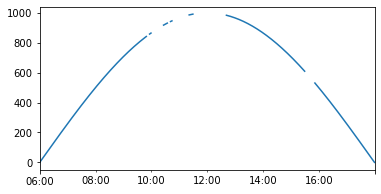

In [120]:
df['GHI'].plot(figsize=(6,3))

As it's evident there are a lot of missing data around 11 am, and many short periods of data (data islands).

For this particular application we would like to remove periods of data which are shorter than 30 minutes, as we suspect these periods may also be effected by whatever error source affected the missing/removed data.

To achieve this, we will use `groupby` to aggregate the data into continious periods. Based on the length of each data period, we will assess whether to remove or keep the data.

The first step is to define the start and stop of a data gap. To identify whether data for each time step is missing we can apply `.isna()`, which retuns a boolean Series. Then we use `.diff()` which for each time step takes the difference the current value and the previous value. So if two consecutive values were missing, there would be no difference and `.diff()` would return False. However, if a value was missing and the previous value was not (and vice versa), the difference would be plus or minus one, signifying the start or end of a data period.

By then taking the cumulative sum of the start/stop time series, each period is thereby assigned a unique iteger, and we have now succesfully distingushed the different periods.

<AxesSubplot:>

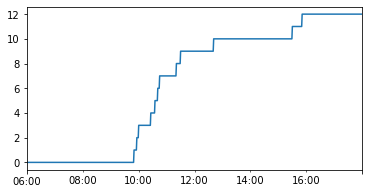

In [121]:
df['gap_start_stop'] = df['GHI'].isna().diff().abs()

df['gap_start_stop_cumsum'] = df['gap_start_stop'].cumsum()

df['gap_start_stop_cumsum'].plot(figsize=(6,3))

The next step is then to determine whether a period should be removed or not. This is where the `groupby` operation becomes extremely handy! We group/split the data into different periods based on the column `gap_start_stop_cumsum` and then for each period we determine how many entries it contains. For this we use the `transform` operation on the grouped periods, which returns a dataframe with the same indexes as the original dataframe. The new column, `group_count`, contains the period length for the period which each time step belongs to.

The values which belongs to periods with less than 30 entires, are then set to nan.

In [124]:
df['ones'] = 1  # dummy column used for groupby

threshold = 30  # threshold value, here set to 30 minutes

df['group_count'] = df.groupby('gap_start_stop_cumsum')['ones'].transform('count')

# set periods shorter than 30 minutes to nan
df.loc[df['group_count']<threshold, 'GHI'] = np.nan

To verify that the data islands have been removed, we visualize the data again:

<AxesSubplot:>

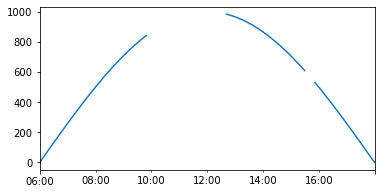

In [125]:
df['GHI'].plot(figsize=(6,3))

It is clear now that all the short data periods have been removed and we are more confident in the validity of our dataset.

Notice how the long period of data between the two gaps has not been removed, as the period is longer than the threshold.

## Part 1: Removing days with 30% flagged data or more

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

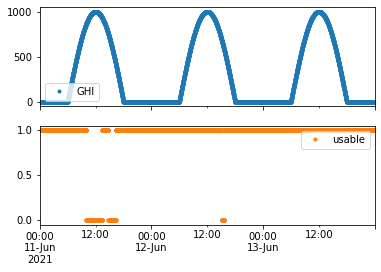

In [143]:
minutes = 1440*3
df = pd.DataFrame(index=pd.date_range('2021-06-11', periods=minutes, freq='1min'))
df['GHI'] = -1000*np.cos(2*np.pi*(np.arange(periods))/1440)
df['GHI'] = df['GHI'].clip(lower=0)

df['usable'] = 1
df.loc['2021-06-11 10:00':'2021-06-11 13:25', 'usable'] = 0
df.loc['2021-06-11 14:45':'2021-06-11 16:20', 'usable'] = 0
df.loc['2021-06-12 15:10':'2021-06-12 15:40', 'usable'] = 0

#df = df[df['GHI']>0]  # equivalent to only daytime periods

df.plot(style='.', subplots=True, sharex=True)

Following a similar methodology as for the previous example, we now 

(0.0, 0.5)

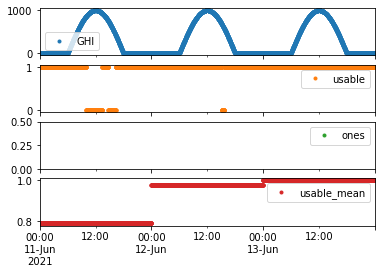

In [144]:
df['ones'] = 1  # dummy column used for groupby

threshold = 0.3  # threshold value
df['usable_mean'] = df.groupby(df.index.date)['usable'].transform('mean')

df.loc[df['usable_mean']<=threshold, 'usable'] = 0

axes = df.plot(style='.', subplots=True, sharex=True)
axes[-2].set_ylim(0, 0.5)
axes[-2].set_ylim(0, 0.5)

<AxesSubplot:>

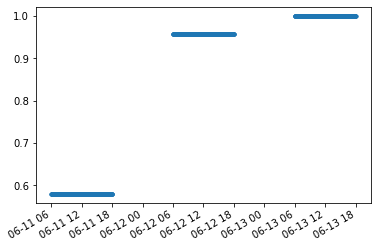

In [116]:
df.groupby(df.index.date)['usable'].transform('mean').plot(style='.')

In [2]:
index = pd.date_range('2021-06-11 06', periods=720, freq='1min')
GHI = -1000*np.cos(2*np.pi*np.linspace(0.25,0.75,720))
df = pd.DataFrame(index=index, data={'GHI': GHI})

Add a column called QC_flag, and add four flagged periods:

In [3]:
df['QC_flag'] = 0
df.loc['2021-06-11 10:00':'2021-06-11 10:25', 'QC_flag'] = 1
df.loc['2021-06-11 10:45':'2021-06-11 11:20', 'QC_flag'] = 1
df.loc['2021-06-11 11:30':'2021-06-11 12:40', 'QC_flag'] = 1
df.loc['2021-06-11 15:39':'2021-06-11 15:40', 'QC_flag'] = 1

Plot GHI data and the QC_flag column:

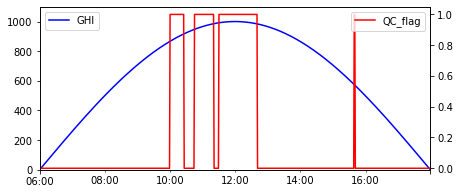

In [4]:
fig, ax = plt.subplots(figsize=(7,3))
twinx = ax.twinx()
df['GHI'].plot(ax=ax, c='b', ylim=[-1,1100])
df['QC_flag'].plot(ax=twinx, c='r', ylim=[-0.01, 1.05])
ax.legend(loc='upper left')
twinx.legend(loc='upper right')

Now we would like to remove the small periods between the flags, as there is a high probability that these periods are in fact also errornous, but might just not have been caught by the automatic QC method.

In this case we will add also flag any unflagged period which is less than 60 minutes:

In [5]:
df['gap_start_stop'] = 0
df.loc[df['QC_flag'].diff().abs()==1, 'gap_start_stop'] = 1
df['gap_start_stop_cumsum'] = df['gap_start_stop'].cumsum()

df['ones'] = 1  # dummy column used for groupby

df.loc[(df.groupby('gap_start_stop_cumsum')['ones'].transform('count') < 60) & (df['QC_flag']==0), 'QC_flag'] = 1

Create the same plot again, this time noticing how the QC_flag variable differs:

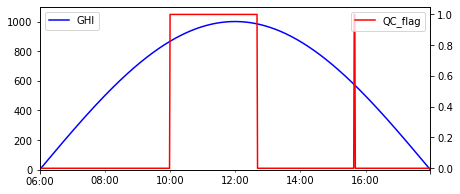

In [6]:
fig, ax = plt.subplots(figsize=(7,3))
twinx = ax.twinx()
df['GHI'].plot(ax=ax, c='b', ylim=[-1,1100])
df['QC_flag'].plot(ax=twinx, c='r', ylim=[-0.01, 1.05])
ax.legend(loc='upper left')
twinx.legend(loc='upper right')